In [ ]:
#!pip install langgraph==0.2.59 langchain-core==0.3.25 langchain-community==0.3.12 groq==0.13.0

In [1]:
import os
import json
import datetime
from typing import TypedDict, List, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from groq import Groq
from dotenv import load_dotenv
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

# Carregar variáveis de ambiente
load_dotenv()

# Inicializar o modelo de linguagem
client = Groq(api_key=os.getenv('GROQ_API_KEY'))
model = "llama3-8b-8192"

In [2]:
# Estruturas de dados para participantes e reuniões
class Participant(TypedDict):
    name: str
    email: str
    calendar: List[Dict[str, any]]  # Lista de eventos no calendário

class MeetingRequest(TypedDict):
    requester: str
    attendees: List[str]
    preferred_times: List[str]
    duration: int  # em minutos
    subject: str
    constraints: Dict[str, any]

class ScheduledMeeting(TypedDict):
    subject: str
    time: datetime.datetime
    duration: int
    attendees: List[str]
    organizer: str

In [3]:
# Definição do estado
class State(TypedDict):
    meeting_request: MeetingRequest
    participants: Dict[str, Participant]
    scheduled_meeting: ScheduledMeeting
    errors: List[str]

In [14]:
def parse_meeting_request(state: State) -> State:
    """
    Analisa a solicitação de reunião em linguagem natural e extrai informações relevantes.
    """
    meeting_request_text = state['meeting_request']['raw_text']
    
    prompt = f"""
Você é um assistente que extrai informações de solicitações de reuniões.
A partir do texto abaixo, extraia:
- Solicitante (nome)
- Lista de participantes (nomes)
- Horários preferenciais (lista de datas e horários)
- Duração da reunião em minutos
- Assunto da reunião
- Restrições adicionais ou preferências

Retorne as informações em formato JSON, sem texto adicional.

Exemplo de formato:
{{
  "requester": "Nome do Solicitante",
  "attendees": ["Participante 1", "Participante 2"],
  "preferred_times": ["2023-10-01 14:00", "2023-10-02 10:00"],
  "duration": 60,
  "subject": "Assunto da Reunião",
  "constraints": {{}}
}}

Texto da solicitação:
{meeting_request_text}
        """
    

    chat_completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": prompt},
        ]
    )
    response = chat_completion.choices[0].message
    try:
        meeting_info = json.loads(response.content)
        state['meeting_request'].update(meeting_info)
    except json.JSONDecodeError as e:
        state['errors'].append(f"Erro ao analisar a solicitação: {e}")
    return state

In [15]:
def check_availability(state: State) -> State:
    """
    Verifica a disponibilidade dos participantes nos horários preferenciais.
    """
    available_times = []
    for time_str in state['meeting_request']['preferred_times']:
        time_obj = datetime.datetime.strptime(time_str, "%Y-%m-%d %H:%M")
        duration = datetime.timedelta(minutes=state['meeting_request']['duration'])
        end_time = time_obj + duration
        
        # Verificar disponibilidade de todos os participantes
        all_available = True
        for attendee in state['meeting_request']['attendees']:
            calendar = state['participants'][attendee]['calendar']
            for event in calendar:
                event_start = event['start_time']
                event_end = event['end_time']
                # Se houver conflito, marcar como indisponível
                if (time_obj < event_end) and (end_time > event_start):
                    all_available = False
                    break
            if not all_available:
                break
        if all_available:
            available_times.append(time_obj)
    
    if available_times:
        # Agendar no primeiro horário disponível
        state['scheduled_meeting'] = {
            "subject": state['meeting_request']['subject'],
            "time": available_times[0],
            "duration": state['meeting_request']['duration'],
            "attendees": state['meeting_request']['attendees'],
            "organizer": state['meeting_request']['requester']
        }
    else:
        state['errors'].append("Não foi possível encontrar um horário disponível.")
    return state

In [16]:
def send_invitations(state: State) -> State:
    """
    Envia convites para os participantes.
    """
    if 'scheduled_meeting' not in state:
        state['errors'].append("Nenhuma reunião agendada para enviar convites.")
        return state
    
    meeting = state['scheduled_meeting']
    for attendee in meeting['attendees']:
        email = state['participants'][attendee]['email']
        # Aqui você implementaria o envio de email real
        print(f"Enviando convite para {attendee} ({email}) para a reunião '{meeting['subject']}' em {meeting['time']}.")
    return state

In [17]:
# Inicializar o grafo de estado
workflow = StateGraph(State)

# Adicionar nós
workflow.add_node("parse_meeting_request", parse_meeting_request)
workflow.add_node("check_availability", check_availability)
workflow.add_node("send_invitations", send_invitations)

# Definir as arestas
workflow.add_edge(START, "parse_meeting_request")
workflow.add_edge("parse_meeting_request", "check_availability")
workflow.add_edge("check_availability", "send_invitations")
workflow.add_edge("send_invitations", END)

# Definir o ponto de entrada
workflow.set_entry_point("parse_meeting_request")

# Compilar o grafo
app = workflow.compile()

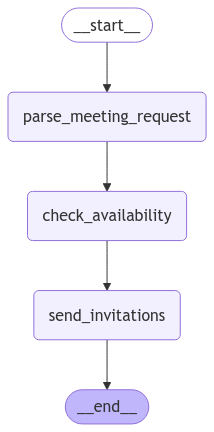

In [18]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [19]:
def schedule_meeting(meeting_request_text: str, participants: Dict[str, Participant]):
    """
    Processa a solicitação de reunião e agenda se possível.
    
    Args:
        meeting_request_text (str): Texto da solicitação em linguagem natural.
        participants (Dict[str, Participant]): Informações dos participantes.
    
    Returns:
        State: Estado final após o processamento.
    """
    initial_state = State(
        meeting_request={"raw_text": meeting_request_text},
        participants=participants,
        scheduled_meeting={},
        errors=[]
    )
    final_state = app.invoke(initial_state)
    return final_state

In [20]:
# Dados de exemplo dos participantes
participants = {
    "Alice": {
        "name": "Alice",
        "email": "alice@example.com",
        "calendar": [
            {"start_time": datetime.datetime(2023, 10, 1, 9, 0), "end_time": datetime.datetime(2023, 10, 1, 10, 0)},
            {"start_time": datetime.datetime(2023, 10, 1, 14, 0), "end_time": datetime.datetime(2023, 10, 1, 15, 0)},
        ]
    },
    "Bob": {
        "name": "Bob",
        "email": "bob@example.com",
        "calendar": [
            {"start_time": datetime.datetime(2023, 10, 1, 11, 0), "end_time": datetime.datetime(2023, 10, 1, 12, 0)},
            {"start_time": datetime.datetime(2023, 10, 1, 16, 0), "end_time": datetime.datetime(2023, 10, 1, 17, 0)},
        ]
    },
    "Carlos": {
        "name": "Carlos",
        "email": "carlos@example.com",
        "calendar": [
            {"start_time": datetime.datetime(2023, 10, 1, 13, 0), "end_time": datetime.datetime(2023, 10, 1, 14, 0)},
            {"start_time": datetime.datetime(2023, 10, 1, 15, 0), "end_time": datetime.datetime(2023, 10, 1, 16, 0)},
        ]
    },
}

In [21]:
# Solicitação de reunião em linguagem natural
meeting_request_text = """
Olá,

Gostaria de agendar uma reunião sobre o projeto X. Seria ideal se pudéssemos nos reunir amanhã às 10h ou às 15h. A reunião deve durar cerca de 60 minutos.

Participantes: Alice, Bob e Carlos.

Atenciosamente,
Maria
"""

In [22]:
# Executar o agendamento
final_state = schedule_meeting(meeting_request_text, participants)

Enviando convite para Alice (alice@example.com) para a reunião 'Projeto X' em 2023-10-01 10:00:00.
Enviando convite para Bob (bob@example.com) para a reunião 'Projeto X' em 2023-10-01 10:00:00.
Enviando convite para Carlos (carlos@example.com) para a reunião 'Projeto X' em 2023-10-01 10:00:00.


In [23]:

# Verificar se houve erros
if final_state['errors']:
    print("Erros encontrados:")
    for error in final_state['errors']:
        print(f"- {error}")
else:
    meeting = final_state['scheduled_meeting']
    print(f"Reunião agendada com sucesso!\nAssunto: {meeting['subject']}\nHorário: {meeting['time']}\nParticipantes: {', '.join(meeting['attendees'])}")

Reunião agendada com sucesso!
Assunto: Projeto X
Horário: 2023-10-01 10:00:00
Participantes: Alice, Bob, Carlos
